# A Guided Tour of Ray Core: Remote Tasks & Ray Objects

© 2019-2023, Anyscale. All Rights Reserved

### Introduction

Ray enables arbitrary Python functions to be executed asynchronously on separate Python workers. These asynchronous Ray functions are called “tasks.” You can specify task's resource requirements in terms of CPUs, GPUs, and custom resources. These resource requests are used by the cluster scheduler to distribute tasks across the cluster for parallelized execution.  

|<img src="https://technical-training-assets.s3.us-west-2.amazonaws.com/Ray_Core/python_to_ray_concept_map.png" height="55%" width="50%">|
|:--|
|Transforming Python code into Ray Tasks, Actors, and Immutable Ray objects.|

|<img src="https://technical-training-assets.s3.us-west-2.amazonaws.com/Ray_Core/python_to_ray_task_map.png" height="55%" width="50%">|
|:--|
|Transforming Python function into Ray Tasks|

### Learning objectives
In this this tutorial, you'll learn about:
 * Remote Task Parallel Pattern
 * Stateless remote functions as distributed tasks
 * Serial vs Parallel execution 
 * Understand the concept of a Ray task 
 * Easy API to convert an existing Python function into a Ray remote task
 * Walk through examples comparing serial vs. distributed Python functions and Ray tasks respectively
 * How to use Ray Objects

In [1]:
import os
import time
import logging
import math
import random
from pathlib import Path
from typing import Tuple, List
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import tqdm
import ray

## 1. Tasks Parallel Pattern

Ray converts decorated functions with `@ray.remote` into stateless tasks, scheduled anywhere on a Ray node's worker in the cluster. 

Where they will be executed on the cluster (and on what node by which worker process), you don't have to worry about its details. All that is taken care for you. Nor do 
you have to reason about it — all that burden is Ray's job. You simply take your existing Python functions and covert them into 
distributed stateless *Ray Tasks*: **as simple as that!**

### Serial vs Parallelism Execution

Serial tasks as regular Python functions are executed in a sequential manner, as shown
in the diagram below. If I launch ten tasks, they will run on a single worker, one after the other.

 
|<img src="https://technical-training-assets.s3.us-west-2.amazonaws.com/Overview_of_Ray/sequential_timeline.png" width="70%" loading="lazy">|
|:--|
|Timeline of sequential tasks, one after the other.|


Compared to serial execution, a Ray task executes in parallel, scheduled on different workers. The Raylet will schedule these task based on [scheduling policies.](https://docs.ray.io/en/latest/ray-core/scheduling/index.html#ray-scheduling-strategies)

|<img src="https://technical-training-assets.s3.us-west-2.amazonaws.com/Overview_of_Ray/distributed_timeline.png" width="70%" loading="lazy">|
|:--|
|Sample timeline with ten tasks running across 4 worker nodes in parallel.|


Let's look at some tasks running serially and then in parallel. For illustration, we'll use a the following tasks:
 * Computing value of pi using the monte carlo method
 * Transforming and processing large high-resolution images

But first, some basic concepts: There are a few key differences between an original Python function and the decorated one:

**Invocation**: The regular version is called with `func_name()`, whereas the remote Ray version is called with `func_name.remote()`. Keep this pattern in mind for all Ray remote execution methods.

**Mode of execution and return values**: A Python `func_name()` executes synchronously and returns the result of the function, whereas a Ray task `func_name.remote()` immediately returns an `ObjectRef` (a future) and then executes the task in the background on a remote worker process. 

The result of the future is obtained by calling `ray.get(ObjectRef)` on the `ObjectRef`. This is a blocking function.

Let's launch a Ray cluster on our local machine.

In [2]:
if ray.is_initialized:
    ray.shutdown()
ray.init(logging_level=logging.ERROR)

Python version:,3.10.12
Ray version:,2.7.1
Dashboard:,http://127.0.0.1:8266


In [3]:
# Get the number of cores 
NUM_OF_CORES = os.cpu_count()

### Example 1:  Monte Carlo simulation of estimating π

Let's estimate the value of π using a [Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) method. We randomly sample points within a 2x2 square. We can use the proportion of the points that are contained within the unit circle centered at the origin to estimate the ratio of the area of the circle to the area of the square. 

Given we know that the true ratio to be π/4, we can multiply our estimated ratio by 4 to approximate the value of π. The more points that we sample to calculate this approximation, the closer we get to true value of π to required decimal points.

|<img src="https://technical-training-assets.s3.us-west-2.amazonaws.com/Ray_Core/monte_carlo_pi.png" width="80%" height="80%">|
|:--|
|Estimating the value of π by sampling random points that fall into the circle.|


In [4]:
# Change this to match your cluster scale.
NUM_SAMPLING_TASKS = NUM_OF_CORES
NUM_SAMPLES_PER_TASK = 10_000_000
TOTAL_NUM_SAMPLES = NUM_SAMPLING_TASKS * NUM_SAMPLES_PER_TASK

Define a regular function that computes the number of samples
in the circle. This is done by randomly sampling `num_samples` for
x, y between a uniform value of (-1, 1). Using the [math.hypot](https://docs.python.org/3/library/math.html#math.hypot) function, we
compute if it falls within the circle.

In [5]:
def sampling_task(num_samples: int, task_id: int, verbose=True) -> int:
    num_inside = 0
    for i in range(num_samples):
        x, y = random.uniform(-1, 1), random.uniform(-1, 1)
        # check if the point is inside the circle
        if math.hypot(x, y) <= 1:
            num_inside += 1
    if verbose:
        print(f"Task id: {task_id} | Samples in the circle: {num_inside}")
    return num_inside

### Function for serial execution
Define a function to run this serially, by launcing `NUM_SAMPLING_TASKS` serial tasks in a comprehension list.

In [6]:
def run_serial(sample_size) -> List[int]:
    results = [sampling_task(sample_size, i+1) for i in range(NUM_SAMPLING_TASKS)]
    return results

### Function for distributed execution

Define a function to run this as a remote Ray task, which invokes our sampling function, but since it's decorated
with `@ray.remote`, the task will run on a worker process, tied to a core, on the Ray cluster.

In [7]:
@ray.remote
def sample_task_distribute(sample_size, i) -> object:
    return sampling_task(sample_size, i)


In [8]:
def run_disributed(sample_size) -> List[int]:
    # Launch Ray remote tasks in a comprehension list, each returns immediately with a future ObjectRef 
    # Use ray.get to fetch the computed value; this will block until the ObjectRef is resolved or its value is materialized.
    results = ray.get([
            sample_task_distribute.remote(sample_size, i+1) for i in range(NUM_SAMPLING_TASKS)
        ])
    return results

### Calculate the value of π
Define a function to calculate the value of π by getting all number of samples inside the circle from the sampling tasks and calculate π.

In [9]:
def calculate_pi(results: List[int]) -> float:
    total_num_inside = sum(results)
    pi = (total_num_inside * 4) / TOTAL_NUM_SAMPLES
    return pi

### Run calculating π serially

In [10]:
print(f"Running {NUM_SAMPLING_TASKS} tasks serially....")

Running 10 tasks serially....


In [11]:
%%time
results = run_serial(NUM_SAMPLES_PER_TASK)
pi = calculate_pi(results)

Task id: 1 | Samples in the circle: 7852412
Task id: 2 | Samples in the circle: 7855329
Task id: 3 | Samples in the circle: 7852361
Task id: 4 | Samples in the circle: 7855061
Task id: 5 | Samples in the circle: 7853935
Task id: 6 | Samples in the circle: 7851757
Task id: 7 | Samples in the circle: 7852140
Task id: 8 | Samples in the circle: 7851347
Task id: 9 | Samples in the circle: 7853092
Task id: 10 | Samples in the circle: 7854000
CPU times: user 38.7 s, sys: 206 ms, total: 38.9 s
Wall time: 38.9 s


In [12]:
print(f"Estimated value of π is: {pi:5f}")

Estimated value of π is: 3.141257


### Run calculating π with Ray distributed tasks

In [13]:
%%time
results = run_disributed(NUM_SAMPLES_PER_TASK)
pi = calculate_pi(results)

(sample_task_distribute pid=79985) Task id: 6 | Samples in the circle: 7856120
CPU times: user 14 ms, sys: 10.3 ms, total: 24.3 ms
Wall time: 5.15 s


In [14]:
print(f"Estimated value of π is: {pi:5f}")

Estimated value of π is: 3.141645


### Recap
With Ray, we see an a speed up 🚅 of **~7X**. 
But what if we decrease the number of samples? Do we get an accurate represenation of π? Try it for yourself. 

In [15]:
NUM_SAMPLES_PER_TASK = 1_000_000

### Example 2:  How to use Ray distributed tasks for image transformation and computation with Ray Objects
For this example, we will simulate a compute-intensive task by transforming and computing some operations on large high-resolution images. These tasks are not uncommon in image classification in a DNN for training and transforming
images. 

PyTorch `torchvision.transforms` API provides many transformation APIs. We will use a couple here, along with some `numpy` and `torch.tensor` operations. Our tasks will perform the following compute-intensive transformations:

 1. Use PIL APIs to [blur the image](https://pillow.readthedocs.io/en/stable/reference/ImageFilter.html) with a filter intensity
 2. Use Torchvision random [trivial wide augmentation](https://pytorch.org/vision/stable/generated/torchvision.transforms.TrivialAugmentWide.html#torchvision.transforms.TrivialAugmentWide)
 3. Convert images into numpy array and tensors and do numpy and torch tensor operations such as [transpose](https://pytorch.org/docs/stable/generated/torch.transpose.html), element-wise [multiplication](https://pytorch.org/docs/stable/generated/torch.mul.html) with a random integers
 4. Do more exponential [tensor power](https://pytorch.org/docs/stable/generated/torch.pow.html) and [multiplication with tensors](https://pytorch.org/docs/stable/generated/torch.mul.html)
 5. Use Ray objects to populate images for task's transformation

The goal is to compare execution times running these task serially vs. distributed as a Ray Task.

|<img src="https://technical-training-assets.s3.us-west-2.amazonaws.com/Ray_Core/images_for_transformation.png" width="70%" height="40%"> |
|:--|
|High resolution images for transformation and computation.|


In [16]:
import tasks_helper_utils as t_utils

(sample_task_distribute pid=79986) Task id: 10 | Samples in the circle: 7854583


Define some constants that can be tweaked for experimentation with different batch sizes as part of your exercsie.

In [17]:
DATA_DIR = Path(os.getcwd() + "/task_images")
# BATCHES = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
BATCHES = [25, 50, 75, 100]
SERIAL_BATCH_TIMES = []
DISTRIBUTED_BATCH_TIMES = []

In [18]:
# Define a Ray task to transform, augment and do some compute intensive tasks on an image
@ray.remote
def augment_image_distributed(image_ref: object, fetch_image) -> List[object]:
    return t_utils.transform_image(image_ref, fetch_image=fetch_image)

In [19]:
# Define a function to run these transformation tasks serially, on a single node, single core
def run_serially(img_list_refs: List) -> List[Tuple[int, float]]:
    transform_results = [t_utils.transform_image(image_ref, fetch_image=True) for image_ref in tqdm.tqdm(img_list_refs)]
    return transform_results

In [20]:
# Define function to run these transformation tasks distributed
def run_distributed(img_list_refs:List[object]) ->  List[Tuple[int, float]]:
    return ray.get([augment_image_distributed.remote(img, False) for img in tqdm.tqdm(img_list_refs)])

Let's download 100 large images, each betwen 5-20 MB+ with high-resolution greater (4000, 3500) pixels. It will only download once on local host or headnode.

In [21]:
# Check if dir exists. If so ignore download.
# Just assume we have done from a prior run
if not os.path.exists(DATA_DIR):
    os.mkdir(DATA_DIR)
    print(f"downloading images ...")
    for url in tqdm.tqdm(t_utils.URLS):
        t_utils.download_images(url, DATA_DIR)

downloading images ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:56<00:00,  2.37s/it]


In [22]:
# Fetch the the entire image list
image_list = list(DATA_DIR.glob("*.jpg"))
image_list[:2]

[PosixPath('/Users/jules/git-repos/devAIWorld23/task_images/6102003.jpg'),
 PosixPath('/Users/jules/git-repos/devAIWorld23/task_images/14661919.jpg')]

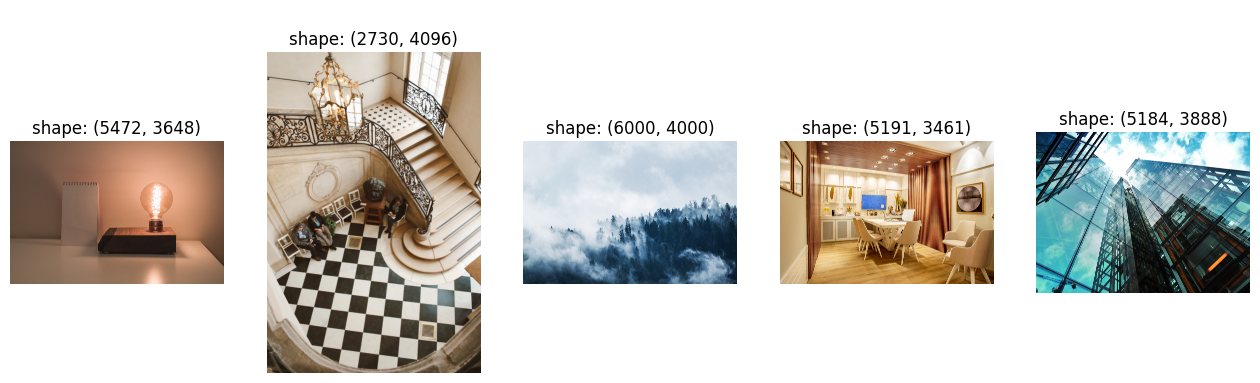

In [23]:
# Let's look at some of random images, five for now, we are working with. Nice to be one with the data.
t_utils.display_random_images(image_list, n=5)

### Populate our Ray object store
Since our images are large, let's put them in the [Ray Distributed object store](https://docs.ray.io/en/latest/ray-core/key-concepts.html#objects). This allows any
task scheduled a remote node to have access to the images. 
|<img src="https://technical-training-assets.s3.us-west-2.amazonaws.com/Overview_of_Ray/object_store.png" width="70%" loading="lazy">|
|:--|
|Diagram of workers in worker nodes using `ray.put()` to store values and using `ray.get()` to retrieve them from each node's object store.|

In [24]:
# Place all images into the object store. Since Ray tasks may be disributed 
# across machines, the DATA_DIR may not be present on a worker. However,
# placing them into the Ray distributed objector provides access to any 
# remote task scheduled on Ray worker
    
images_list_refs = [t_utils.insert_into_object_store(image) for 
                  image in image_list]
images_list_refs[:2]

(raylet) Spilled 2470 MiB, 52 objects, write throughput 4724 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(raylet) Spilled 4761 MiB, 94 objects, write throughput 3872 MiB/s.


[ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000001e1f505),
 ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000002e1f505)]

# Run serially: each image transformation with a Python function

We will iterate through the images with batches of 10 (this can be changed) and process them. To simulate a computer-intensive operation 
on images, we are doing the tensor transformation and computations described above.

In [25]:
for idx in BATCHES:
    # Use the index to get N number of URLs to images
    image_batch_list_refs = images_list_refs[:idx]
    print(f"\nRunning {len(image_batch_list_refs)} tasks serially....")
    
    # Run each one serially
    start = time.perf_counter()
    serial_results = run_serially(image_batch_list_refs)
    end = time.perf_counter()
    elapsed = end - start
    
    # Keep track of batches, execution times as a Tuple
    SERIAL_BATCH_TIMES.append((idx, round(elapsed, 2)))
    print(f"Serial transformations/computations of {len(image_batch_list_refs)} images: {elapsed:.2f} sec")


Running 25 tasks serially....


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.65it/s]


Serial transformations/computations of 25 images: 15.15 sec

Running 50 tasks serially....


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.53it/s]


Serial transformations/computations of 50 images: 32.78 sec

Running 75 tasks serially....


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:49<00:00,  1.51it/s]


Serial transformations/computations of 75 images: 49.62 sec

Running 98 tasks serially....


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [01:08<00:00,  1.43it/s]

Serial transformations/computations of 98 images: 68.37 sec


### Run distributed: each image transformation with a Ray task

Let's create a Ray task for an image within each batch and process them. 

In [26]:
# Iterate over batches, launching Ray task for each image within the processing
# batch
for idx in BATCHES:
    image_batch_list_refs = images_list_refs[:idx]
    print(f"\nRunning {len(image_batch_list_refs)} tasks distributed....")
    
    # Run each one serially
    start = time.perf_counter()
    distributed_results = run_distributed(image_batch_list_refs)
    end = time.perf_counter()
    elapsed = end - start
    
     # Keep track of batchs, execution times as a Tuple
    DISTRIBUTED_BATCH_TIMES.append((idx, round(elapsed, 2)))
    print(f"Distributed transformations/computations of {len(image_batch_list_refs)} images: {elapsed:.2f} sec")


Running 25 tasks distributed....


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 8765.16it/s]


Distributed transformations/computations of 25 images: 6.41 sec

Running 50 tasks distributed....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 10104.32it/s]


Distributed transformations/computations of 50 images: 10.30 sec

Running 75 tasks distributed....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 17026.94it/s]


Distributed transformations/computations of 75 images: 14.09 sec

Running 98 tasks distributed....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 15575.66it/s]


Distributed transformations/computations of 98 images: 20.75 sec


### Compare and plot the serial vs. distributed computational times

In [27]:
# Print times for each and plot them for comparison
print(f"Serial times & batches     : {SERIAL_BATCH_TIMES}")
print(f"Distributed times & batches: {DISTRIBUTED_BATCH_TIMES}")

Serial times & batches     : [(25, 15.15), (50, 32.78), (75, 49.62), (100, 68.37)]
Distributed times & batches: [(25, 6.41), (50, 10.3), (75, 14.09), (100, 20.75)]


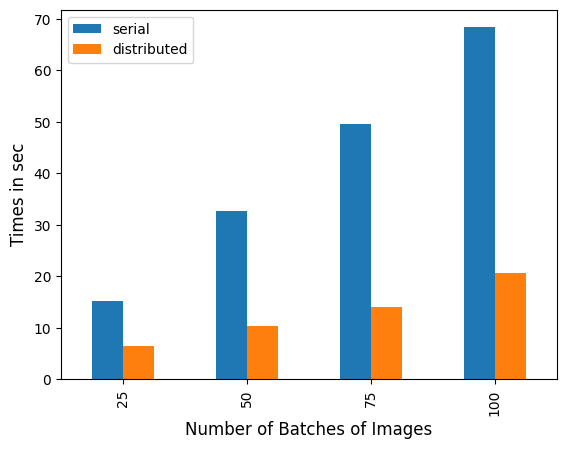

In [28]:
t_utils.plot_times(BATCHES, SERIAL_BATCH_TIMES, DISTRIBUTED_BATCH_TIMES)

### Recap

We can clearly observe that the overall execution times by Ray tasks is in order of **3x** faster 🚅 than serial. Converting an existing serial compute-intensive Python function is as simple as adding the `ray.remote(...)` operator to your Python function. And Ray will handle all the hard bits: scheduling, execution, scaling, memory management, etc.

As you can see the benefits are tangible in execution times with Ray tasks. Try with different batches of images.

In [29]:
ray.shutdown()

### Homework
1. For the Example 3, try different batch sizes, and compare the runnintimes. For example, BATCHES = [20, 40, 60, 80, 100]
2. Read this blog: [Parallelizing Python Code](https://www.anyscale.com/blog/parallelizing-python-code), and try some examples.

### References

1. [Modern Parallel and Distributed Python: A Quick Tutorial on Ray](https://towardsdatascience.com/modern-parallel-and-distributed-python-a-quick-tutorial-on-ray-99f8d70369b8) by Robert Nishihara, co-creator of Ray and co-founder Anyscale
2. [Ray Core Introduction](https://www.anyscale.com/events/2022/02/03/introduction-to-ray-core-and-its-ecosystem) by Jules S. Damji